# Modelling a Simple TablePulseTemplate

This example demonstrates how to set up a simple TablePulseTemplate.

![The pulse we want to model using the qctoolkit](img/example_pulse.png)

Assume we want to model a pulse as depicted by the figure above. Since the structure is relatively simple and relies only on a few critical points between which the values are interpolated (indicated by the crosses in the figure), we will do so by using a `TablePulseTemplate` and setting values at appropriate times. First, let us instantiate a `TablePulseTemplate` object:

In [11]:
from qctoolkit.pulses import TablePulseTemplate
template = TablePulseTemplate(identifier='foo')

For our first try, let's just fix some values for the parameters. Let us set $t_a$ = 2, $v_a$ = 2, $t_b$ = 4, $v_b$ = 3, $t_{end}$ = 6. Our pulse then holds a value of 0 for 2 units of time, then jumps to 2 and subsequently ramps to 3 over the next 2 units of time. Finally, it returns to holding 0 for another 2 units of time. The supporting points for the table are thus (0,0), (2,2), (4,3), (6,0). We add these to our `TablePulseTemplate` object `template` with the correct interpolation strategies as follows:

In [3]:
template.add_entry(0, 0)
template.add_entry(2, 2, interpolation='hold')
template.add_entry(4, 3, interpolation='linear')
template.add_entry(6, 0, interpolation='jump')

Note that we could omit the first instruction: If the time value of the first call to `add_entry` is greater than zero, a starting entry (0,0) is automatically set. Note further that the interpolation set for an entry always applies to the range from the previous entry to the new entry. Thus, the value for the first entry is always ignored. The default value for interpolation is 'hold'. 'hold' and 'jump' differ in that 'hold' will hold the previous value until the new entry is reached while 'jump' will immediately assume the value of the new entry.

We plot `template` to see if everything is correct (ignore the matplotlib warning here):

<IPython.core.display.Javascript object>


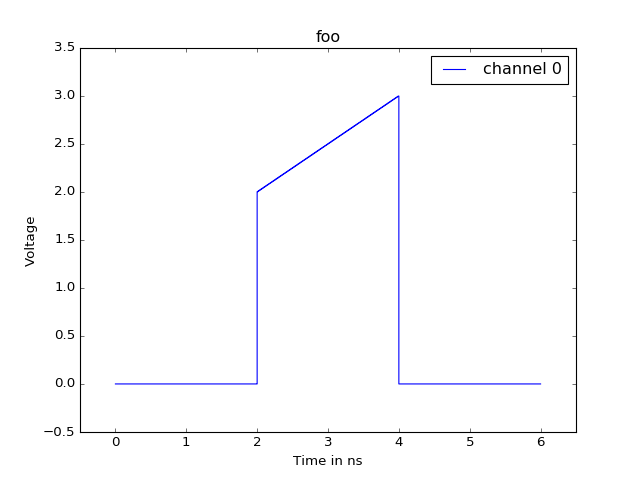

In [3]:
%matplotlib notebook
from qctoolkit.pulses import plot

try:
    plot(template, sample_rate=100)
except:
    pass

Alright, we got what we wanted. 

Note that the time domain in pulse defintions does not correspond to any fixed real world time unit. The mapping from a single time unit in a pulse definition to real time in execution is made by setting a sample rate when converting the pulse templates to waveforms. For more on this, see [The Sequencing Process: Obtaining Pulse Instances From Pulse Templates](04Sequencing.ipynb).

## Introducing Parameters
Now we want to make the template parameterizable. This allows us to reuse the template for pulses with similar structure. Say we would like to have the same pulse, but the intermediate linear interpolation part should last 4 units of time instead of only 2. Instead of creating another template with hardcoded values, we instruct the `TablePulseTemplate` instance to rely on parameters.

In [94]:
param_template = TablePulseTemplate()
param_template.add_entry('ta', 'va', interpolation='hold')
param_template.add_entry('tb', 'vb', interpolation='linear')
param_template.add_entry('tend', 0, interpolation='jump')
from qctoolkit.pulses import PulseTemplateParameterMapping
from qctoolkit.expressions import Expression
from sympy import symbols

from py_expression_eval import Parser, Expression as PyExpression

expres = Expression('2*t')

mapping = {'tend' : expres}


In [138]:
def duration(self):
    d = param_template.__dict__['_TablePulseTemplate__entries'][-1][-1].t
    if isinstance(d,float):
        return Parser().parse( PyExpression( str(d) ) )
    else:
        return Parser().parse( d.name )

d = duration(param_template)

#d.simplify({'tend',-1}).toString()
e = Parser().parse('+'.join([d.toString()]*4) + '-4*tend' + '+2*a')
my_vars = symbols(e.variables())
my_map = dict(zip( e.variables(), my_vars ))

s = e.evaluate(my_map)
a = my_vars[1]
dict([('a','a')])

{'a': 'a'}

In [149]:
d1 = {'Z' :  'K', 's' : 't'}
d2 = {'id1' : 'Z', 'id2' : 'Z'}
d3 = {'s' : 'f', 'x' : 'y'}
def concatenate_dict(x,y,*args):
    result = x.copy()
    for k,v in y.items():
        if v in y:
            result[k] = result[v]
        else:
            result[k] = v
        print(k,v)
    if args:
        return concatenate_dict(result,args[0])
    else:
        return result
concatenate_dict(d1,d2,d3)

id2 Z
id1 Z
s f
x y


{'Z': 'K', 'id1': 'Z', 'id2': 'Z', 's': 'f', 'x': 'y'}

Instead of using numerical values, we simply insert parameter names in our calls to `add_entry`. You can use any combination of numerical values or parameters names here. Note that we also gave our object the optional identifier 'foo'. Our `param_template` thus now defines a set of parameters.

In [5]:
print(param_template.parameter_names)

{'va', 'tb', 'vb', 'tend', 'ta'}


We now have a pulse template that we can instantiate with different parameter values, which we simply provide as a dictionary. To achieve the same pulse as above:

<IPython.core.display.Javascript object>


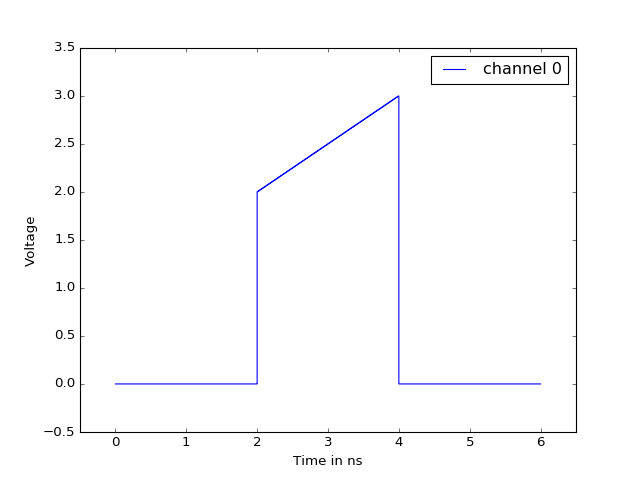

In [6]:
%matplotlib notebook
parameters = {'ta': 2,
              'va': 2,
              'tb': 4,
              'vb': 3,
              'tend': 6}
plot(param_template, parameters, sample_rate=100)

To instantiate the pulse with longer intermediate linear interpolation we now simply adjust the parameter values without touching the `param_template` itself:

<IPython.core.display.Javascript object>


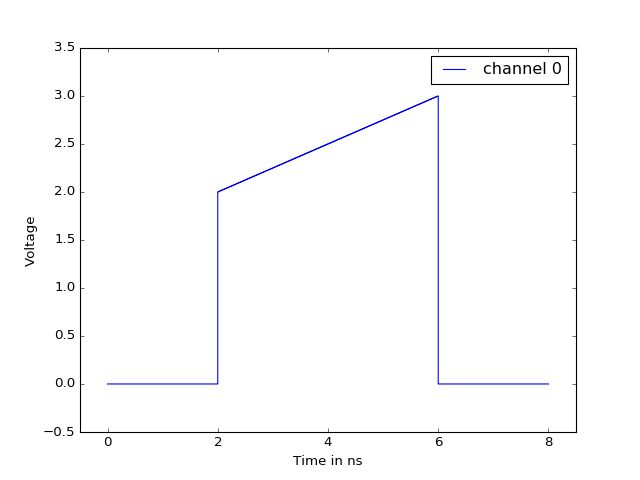

In [7]:
%matplotlib notebook
parameters = {'ta': 2,
              'va': 2,
              'tb': 6,
              'vb': 3,
              'tend': 8}
plot(param_template, parameters, sample_rate=100)